In [1]:
## Packages
'''Import all the necessary packages and modules'''
import pandas as pd
from pycroscopy.io.translators.df_utils.dm_utils import read_dm3
import numpy as np # package for playing with matrices
import matplotlib.pyplot as plt
import sys, os # python modules for interacting with computer
# from sklearn.decomposition import PCA
from tkinter import filedialog # interface for opening a file explorer
from tkinter import * # * imports all files in tkinter
import glob
# from sklearn import preprocessing
import cv2

In [2]:
## Data Directory GUI
'''Getting data directory so data can easily be imported '''
def get_dir(new=True):
    '''Opens a window to select directory if new==False gets current directory
    Returns the directory as a string
    '''
    if new==True:
        root = Tk() # Tk() is a function in tkinter that opens a window
        root.directory = filedialog.askdirectory() # opens explorer window so you can find the folder of choice
        root.withdraw() # closes the tkinter window since it's unnecessary
        oldcwd = os.getcwd() # saves old called working directory (place where data is drawn from) as oldcwd use os.chdir(oldcwd) to go back
        os.chdir(root.directory) # sets new directory
        newcwd = os.getcwd() # saves new directory name as newcwd
        return root.directory
    if new==False:
        cd=os.getcwd()
        return cd
folder=get_dir()

In [3]:
## Load Data use for .csv data
''' Makes a list of all the files with the extension use * to use for importing'''

path = folder + '/'+'*.dm3' # Change '' as needed
file_list=sorted(glob.glob(path))
list(enumerate(file_list)) # list all files and their corresponding index in the list file_list

[(0,
  'Z:/JEOL 3010/Comb Sample PP test/OnOffPump\\ContBeam_.5s_leftside_1.dm3'),
 (1,
  'Z:/JEOL 3010/Comb Sample PP test/OnOffPump\\PulseBeam_2.6_.5s_leftside.dm3'),
 (2,
  'Z:/JEOL 3010/Comb Sample PP test/OnOffPump\\PulseBeam_2.6_.5s_leftside_pumped_no_-dB_1.dm3')]

In [4]:
def load_dm3(filename,get_meta=False, stack=False):
    '''Loads a single dm3 into a numpy array. If get_meta=True gets all corresponding metadata aswell
    Returns an numpy array of the dm3
    '''
    if (stack==True) | (np.array(filename).size!=1):
        
        image_size= read_dm3(filename[0])[0].shape
        num_images=len(filename)
        stack_size=(image_size[0],image_size[1], len(filename)) # set size of data_stack 
        data_stack=np.zeros(stack_size) # Preallocate the data_stack
        meta_size=[]
        '''Determine the size of the meta data'''
        for n in range(len(filename)): 
            meta_size.append(len(list(read_dm3(filename[n])[1].items())))
        meta_dim1=np.max(meta_size)
        meta_stack=np.zeros((meta_dim1,2,len(filename)),dtype=np.object_)
        '''Parse the image intensities from the meta data and load into data_stack and meta_stack'''
        for n in range(len(filename)):
            data_stack[:,:,n]=read_dm3(filename[n])[0]
        if get_meta==True:
            for n in range(len(filename)):
                string_stack=list(read_dm3(filename[n])[1].items())
                if len(string_stack)<meta_dim1:
                    diff=meta_dim1-len(string_stack)
                    for x in range(diff):
                        string_stack.append(([],[]))
                meta_stack[:,:,n]=string_stack # Use meta_stack[:,:,#] to look at the meta_data for file #
            return data_stack, meta_stack
            
        return data_stack
        
    image_size= read_dm3(filename)[0].shape
    image=np.zeros(image_size)
    meta=np.zeros((len(list(read_dm3(filename)[1].items())),2),dtype=np.object_)
    image[:,:]=read_dm3(filename)[0]
    meta[:,:]=list(read_dm3(filename)[1].items())
    if get_meta==True:
        return image, meta
    return image

In [5]:
def shift_image(im,shift,delete=True,fill=0):
    from scipy.ndimage import fourier_shift
    """Shifts image based on scipy.ndimage shift vector.

    Parameters
    ----------
    x : np.array
      Shape N X T.

    shift : sequence
        The size of the box used for filtering.
        If a float, `shift` is the same for all axes. If a sequence, `shift`
        has to contain one value for each axis.

    Returns
    -------
    fourier_shift : ndarray
        The shifted input.

    """
    
    rank=im.ndim
    if hasattr(shift, '__iter__'):
        n_shift = list(shift)
    else:
        n_shift = [shift] * rank  
    fft_im=fourier_shift(np.fft.fftn(im),n_shift)
    shifted_im=np.fft.ifftn(fft_im)
#     return shifted_im,n_shift
    if delete ==True:
        ylim=int(n_shift[0])
        xlim=int(n_shift[1])
        if ylim>=0:
            shifted_im[0:ylim,:]=fill
        if ylim<0:
            shifted_im[ylim:,:]=fill
        if xlim>=0:
            shifted_im[:,0:xlim]=fill
        if xlim<0:
            shifted_im[:,xlim:]=fill
        
    return np.array(shifted_im)

def to_8bit(image):
    im=image.copy()
    im=(im-np.min(im)).real
    im=(im/np.max(im))*255

    return im.astype(int)
def to_binary(image):
    im=image.copy()
    mean=np.mean(im)
    im[im<=mean]=0
    im[im>mean]=1
    return im.astype(int)
def rigid_registration(to_be_registered,reference,pixel_resolution,get_shift=False):
    from skimage.feature import register_translation
    to_be_registered_bin=to_binary(to_be_registered)
    reference_bin=to_binary(reference)
#     to_be_registered_8=to_8bit(to_be_registered_bin)
#     reference_8=to_8bit(reference_bin)
    return to_binary(to_be_registered_bin-reference_bin)
    upsample_factor=1/pixel_resolution
    shift, error, diffphase = register_translation(to_be_registered_8, reference_8, upsample_factor)
    shifted_image=shift_image(to_be_registered,shift)
    if get_shift==True:
        return shifted_image.real, shift
    return shifted_image.real



In [6]:
def coord_to_im(xyz,shape='square'):
    '''Return image from xyz coordinates as an nxm matrix'''
    z=xyz[:,2]
    if shape=='square':
        l=int(xyz.shape[0]**.5)
        image=z.reshape(l,l).T
        return image

    y,x=shape
    image=z.reshape(y,x)
        
    return image

def im_to_coord(image):
    '''Return image xyz coordinates as an X*Yx3 matrix'''
    n,m=image.shape
    yy,xx=np.meshgrid(np.arange(n),np.arange(m))
    x=xx.flatten()
    y=yy.flatten()
    z=image[y.astype(np.int),x.astype(np.int)]
    im_coordinates=np.concatenate((x[:,np.newaxis],y[:,np.newaxis],z[:,np.newaxis]),axis=1)
    return im_coordinates
def make_odd(N):
    X=int(N)
    if X%2:
        return N
    Y=X+1
    return Y
def make_even(N):
    X=int(N)
    if X%2:
        Y=X+1
        return Y
    return N

In [7]:
def outliers(image,quart=5, num_stdev=2, get_cutoff=False, dist='Normal',index=False):
    """Check if value is an outlier based on standard deviations
    quart and num_stdev determine the qualifiers for the outlier (mean +- 1.5*(inner quartile) and mean +- num_stdev *std)
    get_cutoff=True gets the value of the cutoff as determined by num_stdev and quart
    Use dist='Normal' for normal distributions and dist=any other string if not normal dist
    returns boolean array the same size as image where each element is True if an outlier
    
    """

    if dist=='Normal':
        m=np.mean(image)
        std=np.std(image)
        cutoff=num_stdev*std
        lower, upper = m-cutoff, m+cutoff
        outs =np.logical_or(image<=lower,image>=upper)
        if index==False:
            return outs
        if get_cutoff==False:
            return outs
        
        return outs, (lower, upper)
    else:
        """Check if value is an outlier based on percentiles"""
        uquart=100-quart
        q25, q75 = np.percentile(image, quart), np.percentile(image, uquart)
        iqr = q75 - q25
        cut_off = iqr * 1.5
        lower, upper = q25 - cut_off, q75 + cut_off
        outs =np.logical_or(image<=lower,image>=upper)  
        if index==False:
            return np.argwhere(outs)
        if get_cutoff==False:
            return outs

        return outs, (lower, upper)


def local_mean(matrix, x_axis, y_axis, NN=1):
    '''Gets the local mean around a specific index in the matrix
        with NN 1=3x3 -center point = 8 points NN; 2=5x5 -center pt = 24 points!
        Now works with any size by folding around at edges
        Returns the local mean for the specified x and y
        '''

    local_data=[]
    numb=[]
    nsize=matrix.shape[0]-1
    msize=matrix.shape[1]-1
    for n in range(-NN, NN+1,1) :
        for m in range(-NN, NN+1,1):
            if m==0 and n==0:
                continue
                
            if  x_axis+n>nsize and   y_axis+m>msize:  #Cycles around far corner back to 0,0 for arbitrary size
                k = (x_axis+n) 
                k = k % nsize-1
                l = (y_axis+m) 
                l = l % msize-1
                local_data.append(matrix[k, l])
                numb.append([k, l])
                continue
            
            if x_axis+n>nsize:
                k = x_axis+n 
                k = k% nsize-1
                local_data.append(matrix[k, y_axis + m])
                numb.append([k,y_axis + m])
                continue
            if   y_axis+m>msize:
                l = (y_axis+m) 
                l = l % msize-1
                local_data.append(matrix[x_axis +n, l])
                numb.append([x_axis, l])
                continue
          
            local_data.append(matrix[x_axis+n,y_axis+m])
            numb.append([x_axis+n,y_axis+m])
             
    loc_mean=np.mean(local_data)        
        
    return loc_mean    
    
def remove_outliers(image,NN=1,quart=5,num_stdev=2, get_out=False, dist='Normal'):
    '''Takes an image (numpy array) and replaces outliers (determined by outliers function)
    with the local means determined by the local mean function
    Returns the image with the outliers removed.
    If get_out=True it returns the values of the outliers from the image
    '''
    if dist=='Normal':
        if get_out==False:
            outlier_bool= outliers(image, num_stdev=num_stdev,get_cutoff=get_out, dist=dist)
        if get_out==True:
            outlier_bool, cutoffs= outliers(image, num_stdev=num_stdev,get_cutoff=get_out, dist=dist)
        outlier_index=np.argwhere(outlier_bool==True)
        outliers_removed=image.copy()
        for [i,j] in outlier_index: # looks at positions where true only - faster than looking at all values      
            loc_mean=local_mean(image, i, j, NN)
            outliers_removed[i,j] = loc_mean # replaces all values where true with the local mean

        if get_out ==True:
            return image[outlier_index]

        return outliers_removed
    else:
        if get_out==False:
            outlier_bool= outliers(image, num_stdev=num_stdev, get_cutoff=get_out, dist=dist)
        if get_out==True:
            outlier_bool, cutoffs= outliers(image, num_stdev=num_stdev,get_cutoff=get_out, dist=dist)
        outlier_index=np.argwhere(outlier_bool==True)
        outliers_removed=image.copy()
        for [i,j] in outlier_index: # looks at positions where true only - faster than looking at all values      
            loc_mean=local_mean(image, i, j, NN)
            outliers_removed[i,j] = loc_mean # replaces all values where true with the local mean

        if get_out ==True:
            return image[outlier_index]

        return outliers_removed
    
def diff_outliers(image,quart=5,num_stdev=2,dist='Normal',axis='both',index=False):
    ''' Returns an array of shape image with the outliers (based on X and Y derivatives aka slopes)
    of the image of type True. Outliers are designated by outliers function.
    axis determines the direction of derivate and selecting both combines both derivatives
    If index=True, the function returns the index of where the outliers are in the image.
    '''
    if image.ndim !=2:
        raise ValueError("input not 2 dim (n x m)")
    mat=image
    if axis=='both':
        A0=np.expand_dims(mat[0,:],axis=0)
        A1=np.expand_dims(mat[-1,:],axis=0)
        maty = np.concatenate((mat,A0),axis=0)
        maty1=np.flip(np.concatenate((A1,mat),axis=0),axis=0)
        if dist=='Normal':
            diffy1 = outliers(np.diff(maty,axis=0),num_stdev=num_stdev)
            diffy1a = outliers(np.flip(np.diff(maty1,axis=0),axis=0),num_stdev=num_stdev)
        else:
            diffy1 = outliers(np.diff(maty,axis=0),quart=quart, dist='a')
            diffy1a = outliers(np.flip(np.diff(maty1,axis=0),axis=0),quart=quart,dist='a')
        
        diffy= np.logical_and(diffy1,diffy1a)
               
        B0=np.expand_dims(mat[:,0],axis=1)
        B1=np.expand_dims(mat[:,-1],axis=1)
        matx = np.concatenate((mat,B0),axis=1)
        matx1=np.flip(np.concatenate((B1,mat),axis=1),axis=1)
        if dist=='Normal':
            diffx1 = outliers(np.diff(matx,axis=1),num_stdev=num_stdev)
            diffx1a = outliers(np.flip(np.diff(matx1,axis=1),axis=1),num_stdev=num_stdev)
        else:  
            diffx1 = outliers(np.diff(matx,axis=1),quart=quart,dist='a')
            diffx1a = outliers(np.flip(np.diff(matx1,axis=1),axis=1),quart=quart,dist='a')
        diffx= np.logical_and(diffx1,diffx1a)
        

        diff=np.logical_or(diffx,diffy)
        if index==True:
            return np.argwhere(diff)
        return diff
        
    if axis==0:

        A0=np.expand_dims(mat[0,:],axis=0)
        A1=np.expand_dims(mat[-1,:],axis=0)
        maty = np.concatenate((mat,A0),axis=0)
        maty1=np.flip(np.concatenate((A1,mat),axis=0),axis=0)

        if dist=='Normal':
            diffy1 = outliers(np.diff(maty,axis=0),num_stdev=num_stdev)
            diffy1a = outliers(np.flip(np.diff(maty1,axis=0),axis=0),num_stdev=num_stdev)
        else:
            diffy1 = outliers(np.diff(maty,axis=0),quart=quart, dist='a')
            diffy1a = outliers(np.flip(np.diff(maty1,axis=0),axis=0),quart=quart,dist='a')
        
        diffy= np.logical_and(diffy1,diffy1a)
        if index==True:
            return np.argwhere(diffy)
        return diffy
    if axis==1:
    
        B0=np.expand_dims(mat[:,0],axis=1)
        B1=np.expand_dims(mat[:,-1],axis=1)
        matx = np.concatenate((mat,B0),axis=1)
        matx1=np.flip(np.concatenate((B1,mat),axis=1),axis=1)

        if dist=='Normal':
            diffx1 = outliers(np.diff(matx,axis=1),num_stdev=num_stdev)
            diffx1a = outliers(np.flip(np.diff(matx1,axis=1),axis=1),num_stdev=num_stdev)
        else:  
            diffx1 = outliers(np.diff(matx,axis=1),quart=quart,dist='a')
            diffx1a = outliers(np.flip(np.diff(matx1,axis=1),axis=1),quart=quart,dist='a')
        
        diffx= np.logical_and(diffx1,diffx1a)
        if index==True:
            return np.argwhere(diffx)
        return diffx
def remove_diff_outliers(image,NN=1,quart=5,num_stdev=2,dist='Normal',axis='both',get_out=False, num_out=False):
    '''Removes outliers based on the slopes using the diff_outlier function
    Returns the original image with the difference outliers replaced by the local mean
    if num_out =True it returns number of outliers
    If get_out=True it returns the values of the outliers from the image
    
    
    '''
    outlier_index=diff_outliers(image, quart=quart,num_stdev=num_stdev, dist=dist,axis=axis, index=True)
    outliers_removed=image.copy()
    for [i,j] in outlier_index: # looks at positions where true only - faster than looking at all values      
        loc_mean=local_mean(image, i, j, NN)
        outliers_removed[i,j] = loc_mean # replaces all values where true with the local mean
    if num_out==True:
        return outlier_index.shape[0]
    if get_out ==True:
        return outliers_removed, outliers_removed[outlier_index]

    return outliers_removed

In [116]:
im1=load_dm3(file_list[1])
im2=load_dm3(file_list[2])

In [172]:
def thresh(image,threshtype='local'):
    im=image.copy()
    if threshtype=='global':
        from skimage.filters import threshold_otsu
        thresh = threshold_otsu(im)
    if threshtype=='local':
        from skimage.filters import threshold_sauvola
        thresh = threshold_sauvola(im)
    binary = im> thresh
    return binary.astype(int)
def gaussian_filter(image,sig=3):
    from skimage.filters import gaussian
    im=image.copy()
    g = gaussian(im, sigma=sig)
    return g
def binarize(image,sig=3,threshtype='local'):
    im=image.copy()
    t=thresh(im,threshtype=threshtype)
    filt=gaussian_filter(t,sig)
    binary=thresh(filt,threshtype='global')
    return binary

In [177]:
from skimage import filters
edges = binarize(im1)
c=edges

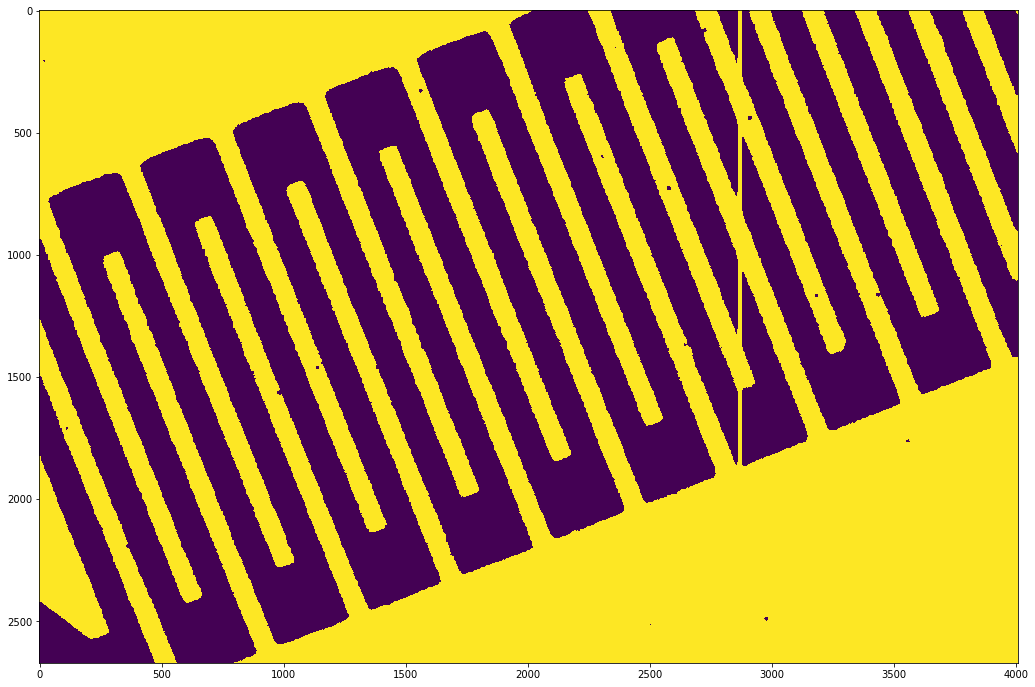

In [178]:
plt.figure(figsize=(18,12))
plt.imshow(c)

In [181]:
a=rigid_registration(im2,im1,.5,get_shift=True)

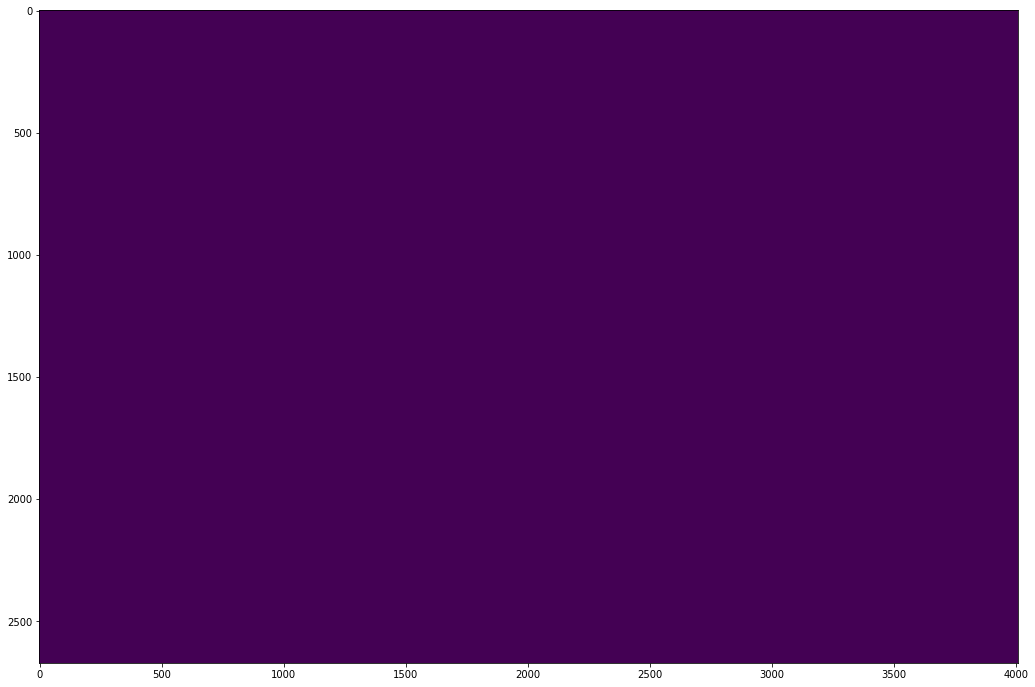

In [182]:
plt.figure(figsize=(18,12))
plt.imshow(a)

In [ ]:
plt.figure(figsize=(18,12))
plt.imshow(to_8bit(a-im2))

In [ ]:
shift_image(image,a)

In [ ]:
image = data.camera()
shift = (-100,100)
# The shift corresponds to the pixel offset relative to the reference image
offset_image = fourier_shift(np.fft.fftn(image), shift)
offset_image = np.fft.ifftn(offset_image)
plt.imshow(offset_image.real)

In [ ]:
register_translation?

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.feature import register_translation
from skimage.feature.register_translation import _upsampled_dft
from scipy.ndimage import fourier_shift

image = data.camera()
shift = (-22.4, 13.32)
# The shift corresponds to the pixel offset relative to the reference image
offset_image = fourier_shift(np.fft.fftn(image), shift)
offset_image = np.fft.ifftn(offset_image)
print("Known offset (y, x): {}".format(shift))

# pixel precision first
shift, error, diffphase = register_translation(image, offset_image)

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Offset image')

# Show the output of a cross-correlation to show what the algorithm is
# doing behind the scenes
image_product = np.fft.fft2(image) * np.fft.fft2(offset_image).conj()
cc_image = np.fft.fftshift(np.fft.ifft2(image_product))
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Cross-correlation")

plt.show()

print("Detected pixel offset (y, x): {}".format(shift))

# subpixel precision
shift, error, diffphase = register_translation(image, offset_image, 100)

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Offset image')

# Calculate the upsampled DFT, again to show what the algorithm is doing
# behind the scenes.  Constants correspond to calculated values in routine.
# See source code for details.
cc_image = _upsampled_dft(image_product, 150, 100, (shift*100)+75).conj()
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Supersampled XC sub-area")


plt.show()

print("Detected subpixel offset (y, x): {}".format(shift))

In [239]:
import numpy as np

def image_correlation(image1, image2):
    """Correlate each n with each m.

    Parameters
    ----------
    x : np.array
      Shape N X T.

    y : np.array
      Shape M X T.

    Returns
    -------
    np.array
      N X M array in which each element is a correlation coefficient.

    """
    im1=im_to_coord(image1)
    im2=im_to_coord(image2)
    z1=im1[:,2]
    z2=im2[:,2]
    mu_z1 = z1.mean()
    mu_z2 = z2.mean()
    n = z1.shape[0]
    s_z1 = z1.std(0, ddof=n - 1)
    s_z2 = z2.std(0, ddof=n - 1)
    cov = np.dot(z1,
                 z2.T) - n * np.dot(mu_z1,
                                  mu_z2)
    return cov / np.dot(s_z1, s_z2)

In [240]:
image_correlation(im1,im2)

0.703316520327459

In [222]:
im1z=im_to_coord(im1)

In [227]:
im1z[:,2].shape

(10709376,)

In [221]:
plt.imshow(generate_correlation_map(im1,im1))

ValueError: shapes (2672,4008) and (2672,4008) not aligned: 4008 (dim 1) != 2672 (dim 0)

In [ ]:
im1n=normalize(im1).astype(np.uint8)
im2n= normalize(im2).astype(np.uint8)

In [ ]:
cor_coef=generate_correlation_map(im1n,im1n)

In [ ]:
plt.figure(figsize=(18,12))
plt.imshow(cor_coef)

In [ ]:
Coord1.shape

In [ ]:
plt.figure(figsize=(18,12))
plt.imshow(im1n,alpha=.5)
plt.imshow(im2n,alpha=.5,cmap='Blues')

In [ ]:
alignImages(im1,im2)

In [ ]:
def alignImages(im1, im2):
    MAX_FEATURES = 5000
    GOOD_MATCH_PERCENT = 0.50
    
    im1Gray = normalize(im1).astype(np.uint8)
    im2Gray = normalize(im2).astype(np.uint8)
    
    orb = cv2.ORB_create(MAX_FEATURES)
    keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)
    
      # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)
    
      # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)
 
    # Remove not so good matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]
      # Draw top matches
    imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
    cv2.imwrite("matches.jpg", imMatches)
    
    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)
 
    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt
   
    # Find homography
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)
 
    # Use homography
    height, width= im2.shape
    im1Reg = cv2.warpPerspective(im1, h, (width, height))  
    return im1Reg, h


In [ ]:
im1Reg.min()

In [ ]:
im1Reg,h=alignImages(im1,im2)

In [ ]:
imS = cv2.resize(im1Reg, (960, 540))
cv2.imshow('preview',imS)
cv2.startWindowThread()
cv2.namedWindow("preview")
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
alignImages(im1,im2)

<Figure size 1296x864 with 0 Axes>

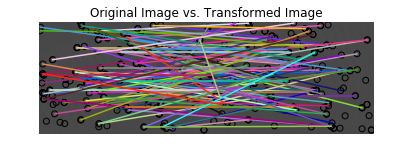

In [254]:
from skimage.feature import ORB, match_descriptors, corner_harris, plot_matches
from skimage.measure import ransac

descriptor_extractor = ORB(n_keypoints=200)

descriptor_extractor.detect_and_extract(im1)
keypoints1 = descriptor_extractor.keypoints
descriptors1 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(im2)
keypoints2 = descriptor_extractor.keypoints
descriptors2 = descriptor_extractor.descriptors
matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)
plt.figure(figsize=(18,12))
fig, ax = plt.subplots(nrows=1, ncols=1)

plt.gray()

plot_matches(ax, im1, im2, keypoints1, keypoints2, matches12)
ax.axis('off')
ax.set_title("Original Image vs. Transformed Image")
plt.show()

In [248]:
matches12

array([[  1,  80],
       [  4, 164],
       [  6, 160],
       [  7,  13],
       [  8,  75],
       [ 10, 188],
       [ 11,  51],
       [ 12,  97],
       [ 14,  10],
       [ 17,  68],
       [ 18,  18],
       [ 19, 116],
       [ 21, 135],
       [ 24,  70],
       [ 28, 173],
       [ 30,  89],
       [ 31,  35],
       [ 34, 134],
       [ 36,  39],
       [ 37, 111],
       [ 40,  82],
       [ 44,  85],
       [ 47,  23],
       [ 49, 152],
       [ 54,   5],
       [ 55,  53],
       [ 57,  42],
       [ 58,  22],
       [ 59, 137],
       [ 60, 148],
       [ 61,  56],
       [ 64,  67],
       [ 68,  45],
       [ 70,   9],
       [ 75,  29],
       [ 78,  73],
       [ 79, 105],
       [ 80,  26],
       [ 81, 195],
       [ 82, 189],
       [ 83,  72],
       [ 84,  20],
       [ 86, 196],
       [ 87,  71],
       [ 90,  38],
       [ 91,  58],
       [ 92, 128],
       [ 94,  24],
       [ 95, 182],
       [ 96,  40],
       [ 97, 102],
       [103,  87],
       [104,

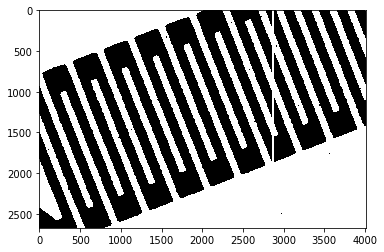

In [243]:
plt.imshow(binarize(im1))

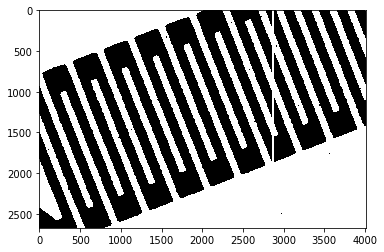

In [215]:
plt.imshow(binarize(im1))

In [210]:
matches12

array([[  1,  80],
       [  4, 164],
       [  6, 160],
       [  7,  13],
       [  8,  75],
       [ 10, 188],
       [ 11,  51],
       [ 12,  97],
       [ 14,  10],
       [ 17,  68],
       [ 18,  18],
       [ 19, 116],
       [ 21, 135],
       [ 24,  70],
       [ 28, 173],
       [ 30,  89],
       [ 31,  35],
       [ 34, 134],
       [ 36,  39],
       [ 37, 111],
       [ 40,  82],
       [ 44,  85],
       [ 47,  23],
       [ 49, 152],
       [ 54,   5],
       [ 55,  53],
       [ 57,  42],
       [ 58,  22],
       [ 59, 137],
       [ 60, 148],
       [ 61,  56],
       [ 64,  67],
       [ 68,  45],
       [ 70,   9],
       [ 75,  29],
       [ 78,  73],
       [ 79, 105],
       [ 80,  26],
       [ 81, 195],
       [ 82, 189],
       [ 83,  72],
       [ 84,  20],
       [ 86, 196],
       [ 87,  71],
       [ 90,  38],
       [ 91,  58],
       [ 92, 128],
       [ 94,  24],
       [ 95, 182],
       [ 96,  40],
       [ 97, 102],
       [103,  87],
       [104,

In [199]:
import numpy as np
from matplotlib import pyplot as plt

from skimage import data
from skimage.util import img_as_float
from skimage.feature import (corner_harris, corner_subpix, corner_peaks,
                             plot_matches, ORB)
from skimage.transform import warp, AffineTransform
from skimage.exposure import rescale_intensity
from skimage.color import rgb2gray
from skimage.measure import ransac


# generate synthetic checkerboard image and add gradient for the later matching
checkerboard = img_as_float(data.checkerboard())
img_orig = np.zeros(list(checkerboard.shape) + [3])
img_orig[..., 0] = checkerboard
gradient_r, gradient_c = (np.mgrid[0:img_orig.shape[0],
                                   0:img_orig.shape[1]]
                          / float(img_orig.shape[0]))
img_orig[..., 1] = gradient_r
img_orig[..., 2] = gradient_c
img_orig = rescale_intensity(img_orig)
img_orig_gray = rgb2gray(img_orig)

# warp synthetic image
tform = AffineTransform(scale=(0.9, 0.9), rotation=0.2, translation=(20, -10))
img_warped = warp(img_orig, tform.inverse, output_shape=(200, 200))
img_warped_gray = rgb2gray(img_warped)

# extract corners using Harris' corner measure
detector_extractor1 = ORB(n_keypoints=5)
detector_extractor2 = ORB(n_keypoints=5)
coords_orig = detector_extractor1.detect_and_extract(corner_harris(img_orig_gray))
coords_warped = detector_extractor2.detect_and_extract(corner_harris(img_warped_gray))

# # determine sub-pixel corner position
# coords_orig_subpix = corner_subpix(img_orig_gray, coords_orig, window_size=9)
# coords_warped_subpix = corner_subpix(img_warped_gray, coords_warped,
#                                      window_size=9)


def gaussian_weights(window_ext, sigma=1):
    y, x = np.mgrid[-window_ext:window_ext+1, -window_ext:window_ext+1]
    g = np.zeros(y.shape, dtype=np.double)
    g[:] = np.exp(-0.5 * (x**2 / sigma**2 + y**2 / sigma**2))
    g /= 2 * np.pi * sigma * sigma
    return g


def match_corner(coord, window_ext=5):
    r, c = np.round(coord).astype(np.intp)
    window_orig = img_orig[r-window_ext:r+window_ext+1,
                           c-window_ext:c+window_ext+1, :]

    # weight pixels depending on distance to center pixel
    weights = gaussian_weights(window_ext, 3)
    weights = np.dstack((weights, weights, weights))

    # compute sum of squared differences to all corners in warped image
    SSDs = []
    for cr, cc in coords_warped:
        window_warped = img_warped[cr-window_ext:cr+window_ext+1,
                                   cc-window_ext:cc+window_ext+1, :]
        SSD = np.sum(weights * (window_orig - window_warped)**2)
        SSDs.append(SSD)

    # use corner with minimum SSD as correspondence
    min_idx = np.argmin(SSDs)
    return coords_warped_subpix[min_idx]


# find correspondences using simple weighted sum of squared differences
src = []
dst = []
for coord in coords_orig_subpix:
    src.append(coord)
    dst.append(match_corner(coord))
src = np.array(src)
dst = np.array(dst)


# estimate affine transform model using all coordinates
model = AffineTransform()
model.estimate(src, dst)

# robustly estimate affine transform model with RANSAC
model_robust, inliers = ransac((src, dst), AffineTransform, min_samples=3,
                               residual_threshold=2, max_trials=100)
outliers = inliers == False


# compare "true" and estimated transform parameters
print(tform.scale, tform.translation, tform.rotation)
print(model.scale, model.translation, model.rotation)
print(model_robust.scale, model_robust.translation, model_robust.rotation)

# visualize correspondence
fig, ax = plt.subplots(nrows=2, ncols=1)

plt.gray()

inlier_idxs = np.nonzero(inliers)[0]
plot_matches(ax[0], img_orig_gray, img_warped_gray, src, dst,
             np.column_stack((inlier_idxs, inlier_idxs)), matches_color='b')
ax[0].axis('off')
ax[0].set_title('Correct correspondences')

outlier_idxs = np.nonzero(outliers)[0]
plot_matches(ax[1], img_orig_gray, img_warped_gray, src, dst,
             np.column_stack((outlier_idxs, outlier_idxs)), matches_color='r')
ax[1].axis('off')
ax[1].set_title('Faulty correspondences')

plt.show()

RuntimeError: ORB found no features. Try passing in an image containing greater intensity contrasts between adjacent pixels.

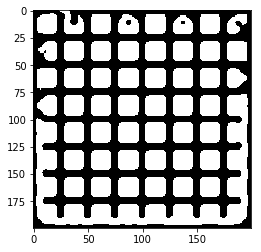

In [203]:
plt.imshow(binarize(corner_harris(img_orig_gray)))

In [183]:
from cv2 import countNonZero, cvtColor

im1Gray = binarize(im1).astype(np.uint8)
im2Gray = binarize(im2).astype(np.uint8)

warp_mode = cv2.MOTION_AFFINE
warp_matrix = np.eye(2, 3, dtype=np.float32)

# Specify the number of iterations.
number_of_iterations = 100

# Specify the threshold of the increment in the correlation 
# coefficient between two iterations
termination_eps = 1e-4

criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 
            number_of_iterations, termination_eps)

# Run the ECC algorithm. The results are stored in warp_matrix.
(cc, warp_matrix) = cv2.findTransformECC(im1Gray, im2Gray, warp_matrix, 
                                         warp_mode, criteria)
# Get the target size from the desired image
target_shape = im1.shape

aligned_image = cv2.warpAffine(
                          im2, 
                          warp_matrix, 
                          (target_shape[1], target_shape[0]), 
                          flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP,
                          borderMode=cv2.BORDER_CONSTANT, 
                          borderValue=0)

In [ ]:
imS = cv2.resize(aligned_image, (960, 540))
cv2.imshow('preview',imS)
cv2.startWindowThread()
cv2.namedWindow("preview")
cv2.waitKey(0)
cv2.destroyAllWindows()

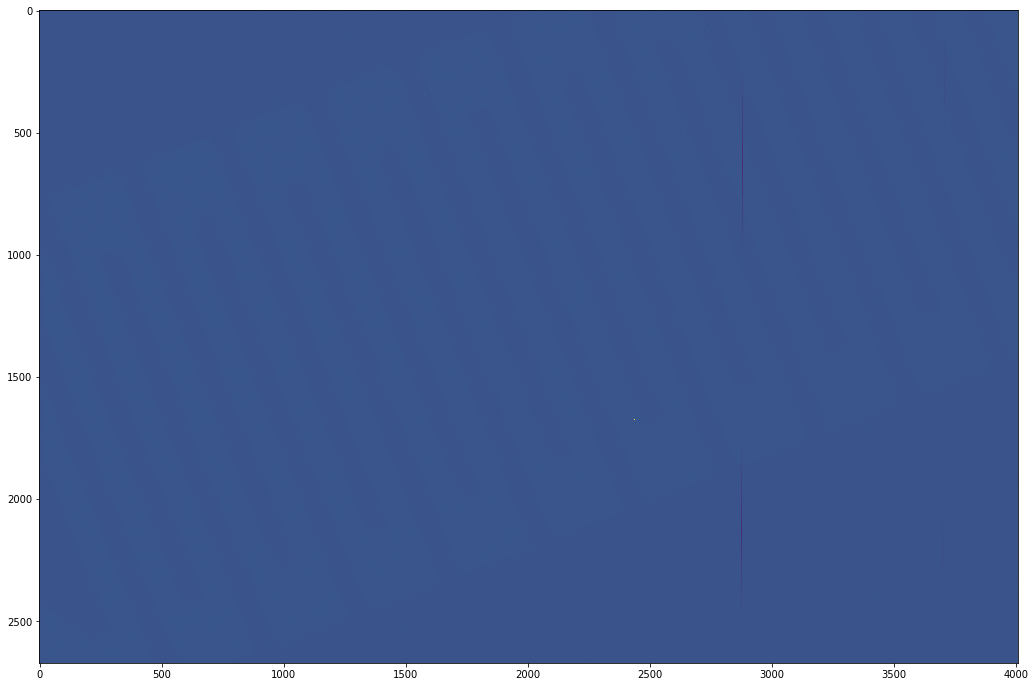

In [185]:
plt.figure(figsize=(18,12))
plt.imshow(aligned_image)
# plt.imshow(im1n,alpha=.5,cmap='Blues')

In [ ]:
def get_gradient(im) :
    # Calculate the x and y gradients using Sobel operator
    grad_x = cv2.Sobel(im,cv2.CV_32F,1,0,ksize=3)
    grad_y = cv2.Sobel(im,cv2.CV_32F,0,1,ksize=3)
 
    # Combine the two gradients
    grad = cv2.addWeighted(np.absolute(grad_x), 0.5, np.absolute(grad_y), 0.5, 0)
    return grad

# Find the width and height of the color image
sz = im.shape
height = int(sz[0] / 3);
width = sz[1]

# Extract the three channels from the gray scale image
# and merge the three channels into one color image
im_color = np.zeros((height,width,3), dtype=np.uint8 )
for i in range(0,3) :
    im_color[:,:,i] = im[ i * height:(i+1) * height,:]

# Allocate space for aligned image
im_aligned = np.zeros((height,width,3), dtype=np.uint8 )

# The blue and green channels will be aligned to the red channel.
# So copy the red channel
im_aligned[:,:,2] = im_color[:,:,2]

# Define motion model
warp_mode = cv2.MOTION_HOMOGRAPHY

# Set the warp matrix to identity.
if warp_mode == cv2.MOTION_HOMOGRAPHY :
        warp_matrix = np.eye(3, 3, dtype=np.float32)
else :
        warp_matrix = np.eye(2, 3, dtype=np.float32)

# Set the stopping criteria for the algorithm.
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 5000,  1e-10)

# Warp the blue and green channels to the red channel
for i in range(0,2) :
    (cc, warp_matrix) = cv2.findTransformECC (get_gradient(im_color[:,:,2]), get_gradient(im_color[:,:,i]),warp_matrix, warp_mode, criteria)

    if warp_mode == cv2.MOTION_HOMOGRAPHY :
        # Use Perspective warp when the transformation is a Homography
        im_aligned[:,:,i] = cv2.warpPerspective (im_color[:,:,i], warp_matrix, (width,height), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    else :
        # Use Affine warp when the transformation is not a Homography
        im_aligned[:,:,i] = cv2.warpAffine(im_color[:,:,i], warp_matrix, (width, height), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP);


# Show final output
cv2.imshow("Color Image", im_color)
cv2.imshow("Aligned Image", im_aligned)
cv2.waitKey(0)